In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=3, suppress=True)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import tslearn
from tslearn.metrics import dtw
from tslearn.clustering import TimeSeriesKMeans

D:\ssd\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
df = pd.read_csv("cars.csv", sep=';', encoding='utf-8')

In [5]:
df.shape

(108536, 18)

In [6]:
df.columns

Index(['brand', 'currency', 'description', 'model', 'price', 'url', 'year',
       'Город', 'Коробка передач', 'Кузов', 'Объем двигателя, л', 'Привод',
       'Растаможен', 'Руль', 'Цвет', 'Пробег', 'Наличие', 'VIN'],
      dtype='object')

In [7]:
df.head(1)

,brand,currency,description,model,price,url,year,Город,Коробка передач,Кузов,"Объем двигателя, л",Привод,Растаможен,Руль,Цвет,Пробег,Наличие,VIN
0,Mercedes-Benz,₸,"полный электропакет , налог уплачен, техосмот...",GL 550,5800000,https://kolesa.kz/a/show/10235750,2008,Актау,типтроник,внедорожник,5.5 (бензин),полный привод,Да,слева,черный металлик,NaN,NaN,NaN


In [8]:
df.year.describe()

count    108536.000000
mean       2003.358231
std           8.957116
min        1913.000000
25%        1996.000000
50%        2004.000000
75%        2011.000000
max        2019.000000
Name: year, dtype: float64

In [9]:
(df.brand.value_counts() > 200).sum()

34

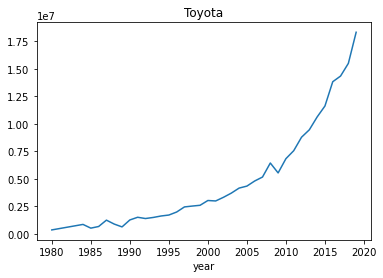

In [10]:
df[df.brand==df.brand.value_counts().index[0]].groupby('year').mean().price.plot()
plt.title('Toyota')
plt.show()

(1980.0, 2020.0)

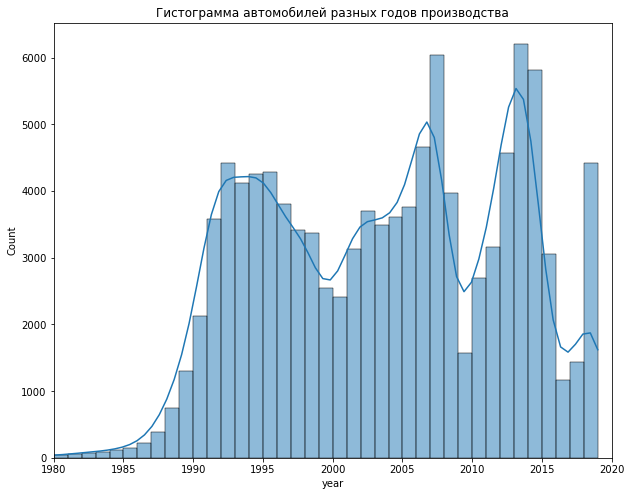

In [11]:
plt.figure(figsize=(10, 8))
sns.histplot(df.year, kde=True, binwidth=1)
plt.title('Гистограмма автомобилей разных годов производства')
plt.xlim(1980, 2020)

In [12]:
all_brands = (df.brand.value_counts() > 200)
brands200 = all_brands[all_brands == True].index.tolist()

In [13]:
df.shape[0] - df[df.brand.isin(brands200)].shape[0]

2840

In [14]:
df.shape[0] - df[(df.brand.isin(brands200)) & (df.year >= 1980) & (df.year < 2019)].shape[0]

5562

После такой чистки теряем всего 5 тысяч строк

In [15]:
only_brands = df[(df.brand.isin(brands200)) & (df.year >= 1980) & (df.year < 2019)][['brand', 'year', 'price']]

In [16]:
grouped_brands = pd.DataFrame(only_brands.groupby(['brand', 'year']).mean().price).unstack()

In [17]:
grouped_brands.isna().sum()

       year
price  1980    25
       1981    25
       1982    24
       1983    22
       1984    17
       1985    17
       1986    14
       1987    16
       1988    16
       1989    12
       1990    13
       1991    12
       1992     7
       1993     6
       1994     8
       1995     6
       1996     5
       1997     6
       1998     4
       1999     7
       2000     6
       2001     5
       2002     5
       2003     4
       2004     4
       2005     4
       2006     4
       2007     3
       2008     2
       2009     3
       2010     3
       2011     3
       2012     2
       2013     1
       2014     1
       2015     4
       2016     3
       2017     4
       2018     7
dtype: int64

In [18]:
only_brands = df[(df.brand.isin(brands200)) & (df.year >= 1992) & (df.year < 2018)][['brand', 'year', 'price']]

In [19]:
grouped_brands = pd.DataFrame(only_brands.groupby(['brand', 'year']).mean().price).unstack()

In [20]:
na_brands = grouped_brands.isna().sum(axis=1)

In [21]:
drop_brands = na_brands[na_brands != 0].index.tolist()

In [22]:
clean_brands = grouped_brands.drop(drop_brands)

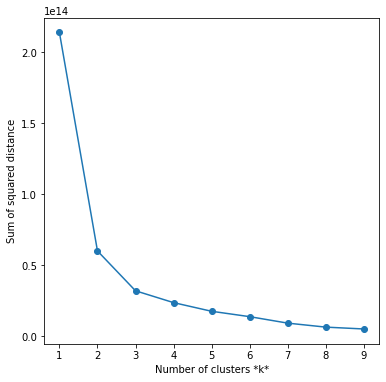

In [23]:
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = TimeSeriesKMeans(n_clusters=k)
    km.fit(clean_brands)
    sse.append(km.inertia_)

plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

3 вполне будет неплохо

In [24]:
model = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=10)
model.fit(clean_brands)

TimeSeriesKMeans(max_iter=10, metric='dtw')

In [25]:
model.labels_

array([0, 1, 2, 2, 0, 2, 2, 1, 2, 1, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2],
      dtype=int64)

In [26]:
clean_brands['label_3'] = model.labels_

In [27]:
clean_brands.head(3)

price                                            \
year               1992          1993          1994          1995   
brand                                                               
Audi       1.175424e+06  1.246108e+06  1.451562e+06  1.643144e+06   
BMW        1.078833e+06  1.302322e+06  1.532793e+06  1.663796e+06   
Chevrolet  1.766667e+06  1.407000e+06  2.125000e+06  1.950000e+06   

                                                                   \
year               1996          1997          1998          1999   
brand                                                               
Audi       1.647303e+06  1.672077e+06  1.728799e+06  1.800324e+06   
BMW        1.781058e+06  1.886984e+06  2.098460e+06  2.203977e+06   
Chevrolet  1.637500e+06  2.150000e+06  1.200000e+06  1.162500e+06   

                                       ...                              \
year               2000          2001  ...          2009          2010   
brand                                  ...                               
Audi       1.897976e+06  2.116316e+06  ...  4.779143e+06  6.202545e+06   
BMW        2.598285e+06  3.073540e+06  ...  7.562515e+06  8.876290e+06   
Chevrolet  1.025000e+07  5.900000e+06  ...  2.934667e+06  2.609016e+06   

                                                                   \
year               2011          2012          2013          2014   
brand                                                               
Audi       8.328557e+06  8.100116e+06  9.281111e+06  1.153223e+07   
BMW        8.001129e+06  9.155296e+06  1.170707e+07  1.202935e+07   
Chevrolet  2.833561e+06  2.841097e+06  3.493561e+06  3.452493e+06   

                                                  label_3  
year               2015        2016          2017          
brand                                                      
Audi       1.166748e+07  19062500.0  1.463612e+07       0  
BMW        2.519429e+07  25679022.2  2.316568e+07       1  
Chevrolet  3.643060e+06   6537375.0  7.103272e+06       2  

[3 rows x 27 columns]

In [28]:
cl = grouped_brands.drop(drop_brands)

In [29]:
unst=pd.DataFrame(cl.unstack(), columns=['price'])

In [30]:
unst = unst.reset_index().drop('level_0', axis=1)

In [31]:
unst['label_3'] = unst.brand.map(dict(zip(clean_brands.index.to_list(), model.labels_)))

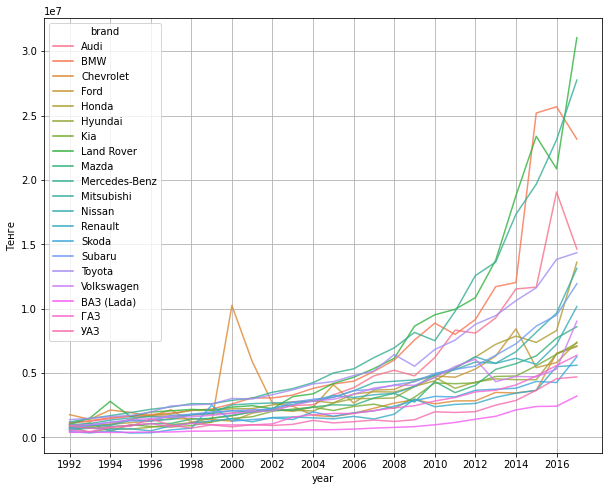

In [32]:
plt.figure(figsize=(10, 8))
sns.lineplot(data=unst, x='year', y='price', hue='brand', alpha=0.8)
plt.grid()
plt.ylabel('Тенге')
plt.xticks(np.arange(1992, 2018, 2))
plt.show()

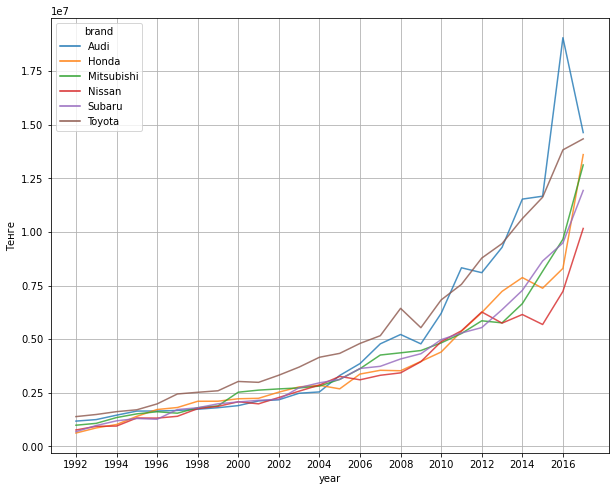

In [33]:
plt.figure(figsize=(10, 8))
sns.lineplot(data=unst[unst.label_3==0], x='year', y='price', hue='brand', alpha=0.8)
plt.grid()
plt.ylabel('Тенге')
plt.xticks(np.arange(1992, 2018, 2))
plt.show()

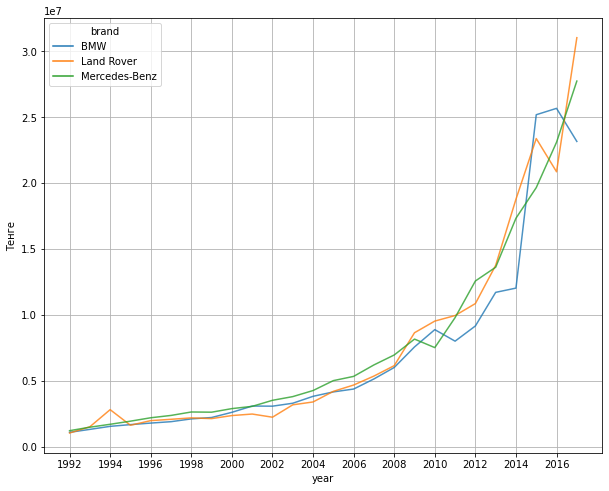

In [34]:
plt.figure(figsize=(10, 8))
sns.lineplot(data=unst[unst.label_3==1], x='year', y='price', hue='brand', alpha=0.8)
plt.grid()
plt.ylabel('Тенге')
plt.xticks(np.arange(1992, 2018, 2))
plt.show()

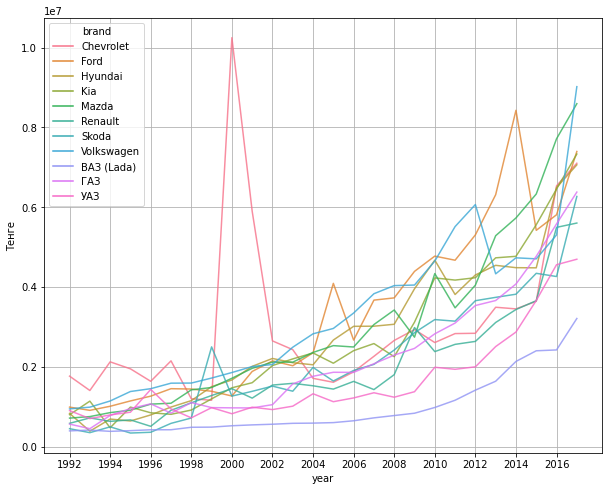

In [35]:
plt.figure(figsize=(10, 8))
sns.lineplot(data=unst[unst.label_3==2], x='year', y='price', hue='brand', alpha=0.8)
plt.grid()
plt.ylabel('Тенге')
plt.xticks(np.arange(1992, 2018, 2))
plt.show()

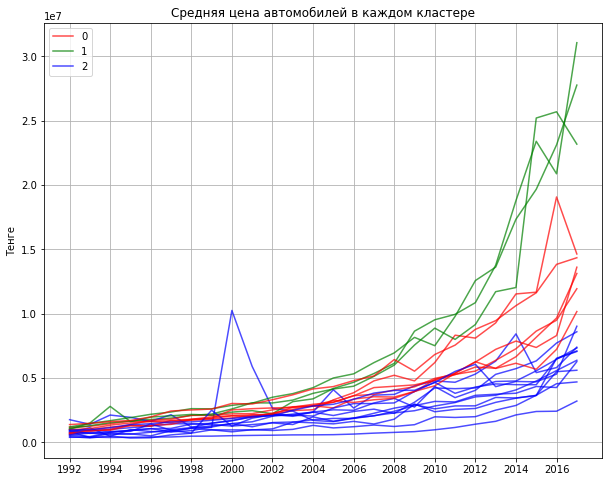

In [36]:
color = {0: 'red', 1: 'green', 2: 'blue'}
labels = [0, 1, 2]
plt.figure(figsize=(10, 8))
for i in range(clean_brands.shape[0]):
    label = clean_brands.iloc[i, -1]
    plt.plot(np.arange(1992, 2018), clean_brands.iloc[i, :-1].to_list(),  color=color[label], label= label if label in labels else '', alpha=0.7)
    if label in labels:
        labels.remove(label)
plt.legend(loc="upper left")
plt.grid()
plt.title('Средняя цена автомобилей в каждом кластере')
plt.ylabel('Тенге')
plt.xticks(np.arange(1992, 2018, 2))
plt.show()